In [1]:
!pip install captum torchvision


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from captum.attr import IntegratedGradients, Saliency
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable


/home/berni/education/counterfactuals/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.MNIST(root='/tmp', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=1, shuffle=True)

trainset = torchvision.datasets.MNIST(root='/tmp', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=512, shuffle=True)



100%|██████████| 9.91M/9.91M [00:02<00:00, 3.90MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 257kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.72MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.92MB/s]


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

model = CNN()


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 5

model.train()
for epoch in range(epochs):
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {100 * (outputs.argmax(dim=1) == labels).float().mean():.2f}%")


Epoch [1/5], Loss: 0.0251, Accuracy: 97.92%
Epoch [2/5], Loss: 0.0010, Accuracy: 100.00%
Epoch [3/5], Loss: 0.0198, Accuracy: 98.96%
Epoch [4/5], Loss: 0.2354, Accuracy: 98.96%
Epoch [5/5], Loss: 0.0001, Accuracy: 100.00%


In [24]:
model.eval()
sample, label = next(iter(testloader))
sample = sample.to(device)
output = model(sample)
pred = output.argmax(dim=1).item()

print(f"True Label: {label.item()}, Predicted: {pred}")


True Label: 9, Predicted: 9


In [25]:
ig = IntegratedGradients(model)
ig_attr = ig.attribute(sample, target=pred, n_steps=50)

# Saliency
saliency = Saliency(model)
sal_attr = saliency.attribute(sample, target=pred)


In [26]:
import torch
import torch.nn.functional as F

def total_variation(x):
    return torch.sum(torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :])) + \
           torch.sum(torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:]))


def generate_counterfactual(model, original_image, original_label, target_class, 
                            steps=200, lr=0.01, lambda_reg=0.01, device='cpu',
                            lambda_tv=0.001):
    """
    Generate a counterfactual image that causes the model to predict `target_class`,
    while remaining visually close to `original_image`.

    Args:
        model: A trained PyTorch model.
        original_image: A single input image (shape: 1x1x28x28).
        original_label: True label of the original image (not directly used here).
        target_class: The class we want the model to predict instead.
        steps: Number of optimization steps.
        lr: Learning rate for the optimizer.
        lambda_reg: Regularization weight to keep image close to the original.
        device: 'cpu' or 'cuda'

    Returns:
        A modified image (counterfactual) tensor.
    """
    model.eval()
    original_image = original_image.to(device)

    # Create a target label tensor
    target = torch.tensor([target_class], device=device)

    # Clone the image and enable gradients for optimization
    x_cf = original_image.clone().detach().to(device)
    x_cf.requires_grad = True

    # Optimizer modifies the image itself
    optimizer = torch.optim.Adam([x_cf], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()

        # Forward pass
        # Inside your loop
        output = model(x_cf)
        loss_target = F.cross_entropy(output, target)
        loss_reg = torch.norm(x_cf - original_image, p=1)
        loss_tv = total_variation(x_cf)
        loss = loss_target + lambda_reg * loss_reg + lambda_tv * loss_tv

        # output = model(x_cf)

        # # Encourage the model to predict the target class
        # loss_target = F.cross_entropy(output, target)

        # # Penalize big changes from the original image (L1 norm)
        # loss_reg = lambda_reg * torch.norm(x_cf - original_image, p=1)

        # # Total loss = classification + regularization
        # loss_tv = lambda_tv * total_variation(x_cf)
        # loss = loss_target + lambda_reg * loss_reg + loss_tv

        # loss = loss_target + loss_reg
        loss.backward()

        # Update the image
        optimizer.step()

        # Keep pixel values in valid range (assumes normalized between 0 and 1)
        x_cf.data = x_cf.data.clamp(0, 1)

    return x_cf.detach()


In [27]:
class_names = [str(i) for i in range(10)]


Original class: 9 → Counterfactual class: 0


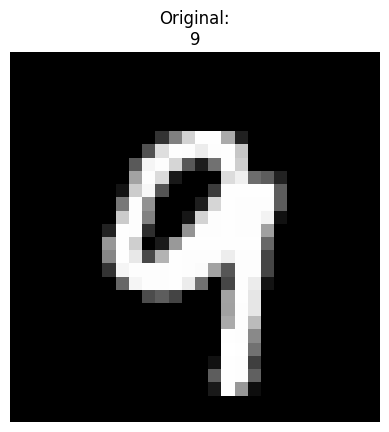

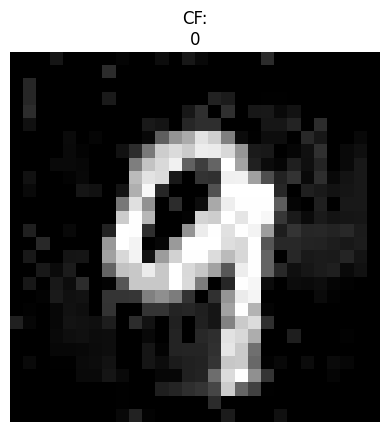

In [28]:
original_image = sample  # shape: (1, 1, 28, 28)
original_label = label.item()
target_class = (original_label + 1) % 10  # just pick a different one

counterfactual = generate_counterfactual(model, original_image, original_label, target_class, device=device)

# Predict
original_pred = model(original_image).argmax(dim=1).item()
cf_pred = model(counterfactual).argmax(dim=1).item()

print(f"Original class: {original_pred} → Counterfactual class: {cf_pred}")


plt.imshow(original_image.squeeze().cpu(), cmap='gray')
plt.title(f"Original:\n{class_names[original_pred]}")
plt.axis('off')
plt.show()
plt.imshow(counterfactual.squeeze().cpu(), cmap='gray')
plt.title(f"CF:\n{class_names[cf_pred]}")
plt.axis('off')
plt.show()


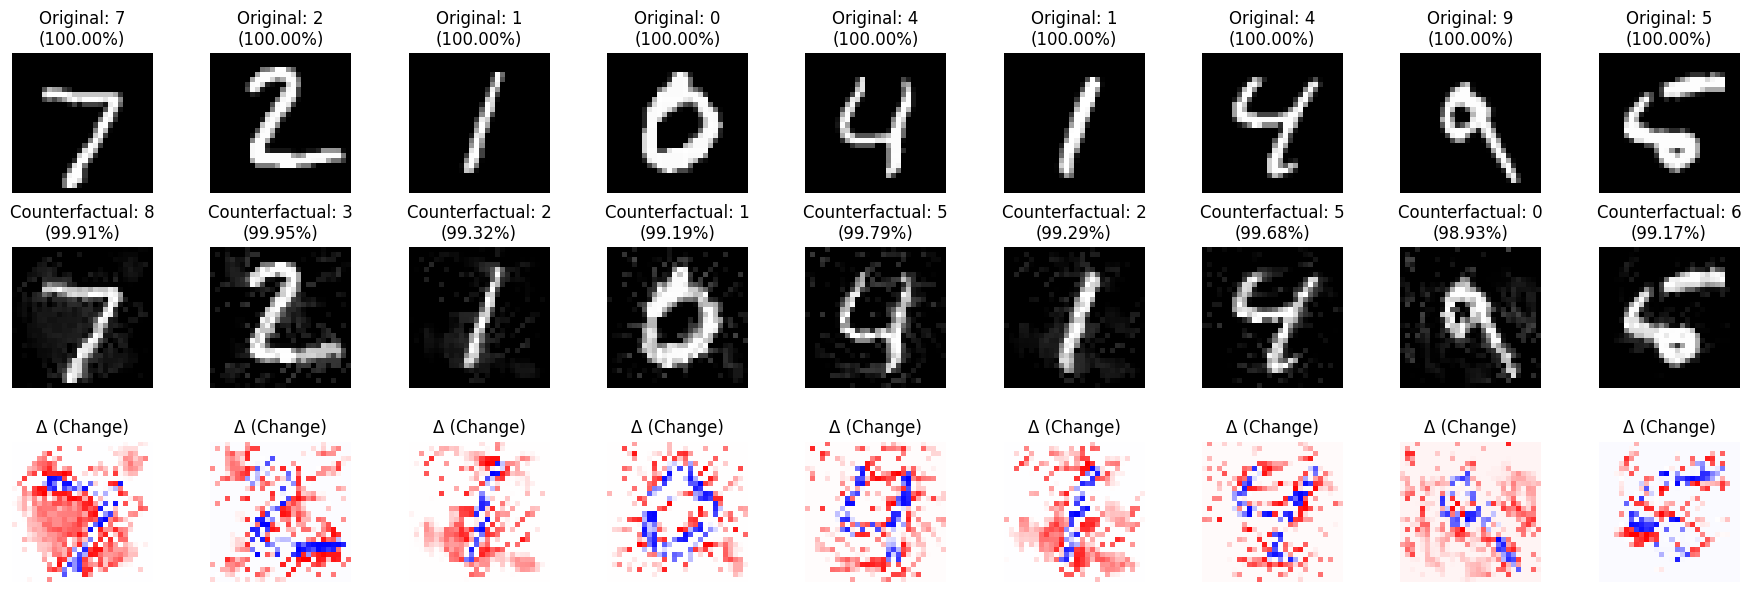

In [29]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

num_images = 9
indices = list(range(num_images))  # You can also randomize these if you want

plt.figure(figsize=(18, 6))

for i in range(num_images):
    sample, label = testloader.dataset[indices[i]]

    # Prepare input
    if sample.ndim == 2:
        original_image = sample.unsqueeze(0).unsqueeze(0).to(device)
    elif sample.ndim == 3:
        original_image = sample.unsqueeze(0).to(device)
    else:
        original_image = sample.to(device)

    # Original prediction
    logits = model(original_image)
    original_probs = F.softmax(logits, dim=1)
    original_class = logits.argmax(dim=1).item()
    original_prob = original_probs[0, original_class].item()
    target_class = (original_class + 1) % 10

    # Generate counterfactual
    cf_image = generate_counterfactual(model, original_image, original_class, target_class, device=device)

    cf_logits = model(cf_image)
    cf_probs = F.softmax(cf_logits, dim=1)
    cf_class = cf_logits.argmax(dim=1).item()
    cf_prob = cf_probs[0, cf_class].item()

    # --- Plot Original ---
    plt.subplot(3, num_images, i + 1)
    plt.imshow(original_image.squeeze().cpu(), cmap='gray')
    plt.title(f"Original: {class_names[original_class]}\n({original_prob:.2%})")
    plt.axis('off')

    # --- Plot Counterfactual ---
    plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(cf_image.squeeze().cpu(), cmap='gray')
    plt.title(f"Counterfactual: {class_names[cf_class]}\n({cf_prob:.2%})")
    plt.axis('off')

    # --- Plot Difference ---
    plt.subplot(3, num_images, 2 * num_images + i + 1)
    plt.imshow((cf_image - original_image).squeeze().cpu(), cmap='bwr')
    plt.title("Δ (Change)")
    plt.axis('off')

plt.tight_layout()
plt.show()
